In [30]:
from astropy.io import votable
from urllib.parse import urlparse, parse_qs
import warnings
from ipyaladin import Aladin
import matplotlib.pyplot as plt
import beakerx
import seaborn as sns
warnings.simplefilter('ignore')

import ipywidgets as widgets

%matplotlib inline

In [11]:
%%javascript
IPython.notebook.kernel.execute("notebook_url = '" + window.location + "'");


<IPython.core.display.Javascript object>

In [13]:
# table URL example: http://vizier.u-strasbg.fr/viz-bin/votable?-source=J%2FApJ%2F720%2F368%2Ftable5&-out.max=9999

query = urlparse(notebook_url).query
params = parse_qs(query)
table_url = params.get('table_url')
if table_url is None:
    print('table_url parameter has not been found in URL!\nEnter a table URL in text field below')
else:
    table_url = table_url[0]
    print(f'Let\'s analyze table {table_url}')
    
table_url_widget = widgets.Text(description='Table URL', value=table_url, layout=widgets.Layout(width='90%'))
table_url_widget

table_url parameter has not been found in URL!
Enter a table URL in text field below


Text(value='', description='Table URL', layout=Layout(width='90%'))

In [14]:
table_url = table_url_widget.value

In [17]:
t = votable.parse_single_table(table_url)

In [22]:
df = t.to_table().to_pandas()

In [23]:
beakerx.TableDisplay(df)

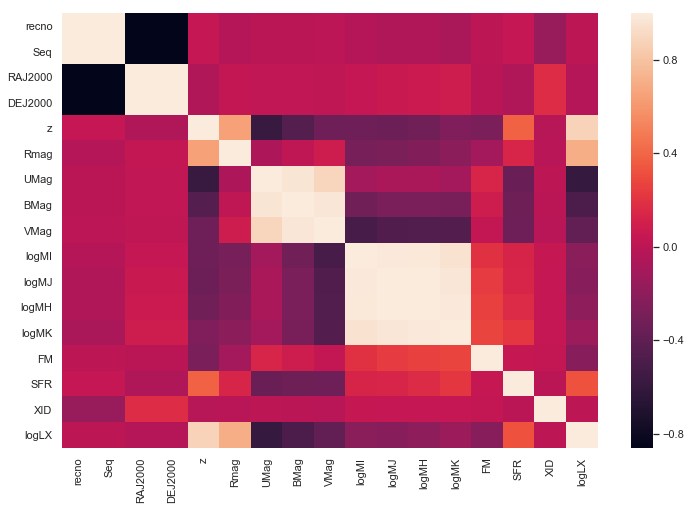

In [28]:
plt.figure(figsize=(12, 8))
sns.set()
corr = df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [32]:
a = Aladin()
a

Aladin(options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'overlay_sur…

In [33]:
a.add_table(t)

AttributeError: 'Table' object has no attribute '__array__'